In [1]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# open cleaned_weight_measurements.pkl
with open('cleaned_weight_measurements.pkl', 'rb') as f:
    df = pickle.load(f)

In [75]:
# remove columns 2 to 5
df = df.drop(df.columns[1:5], axis=1)

In [76]:
# make all values relative to the second columns, except for the first column
df.iloc[:, 1:] = df.iloc[:, 1:].div(df.iloc[:, 1], axis=0) * 100

In [77]:
# melt the dataframe to have three columns: 'name', 'date', and 'weight'
melted_df = df.melt(id_vars=["Name"], var_name="Date", value_name="weight")
# convert 'Date' to datetime
melted_df['Date'] = pd.to_datetime(melted_df['Date'], format='%Y-%m-%d')
# rename 'Name' to 'subject'
melted_df.rename(columns={'Name': 'subject', "Date": 'date'}, inplace=True)

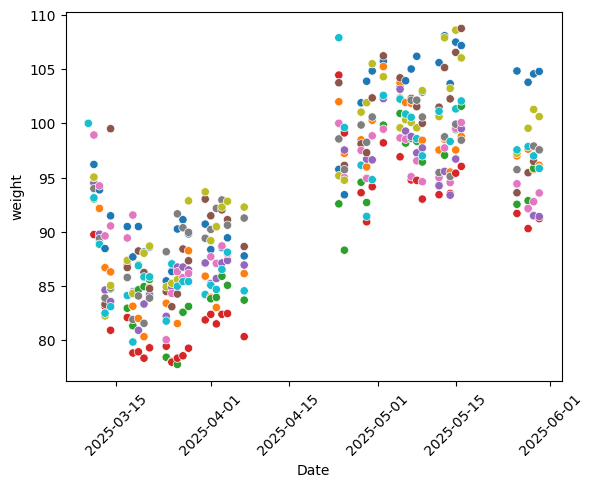

In [78]:
sns.scatterplot(data=melted_df, x='date', y='weight', hue='subject')
plt.xticks(rotation=45)
plt.xlabel('Date')
# remove legend
plt.legend([], [], frameon=False)

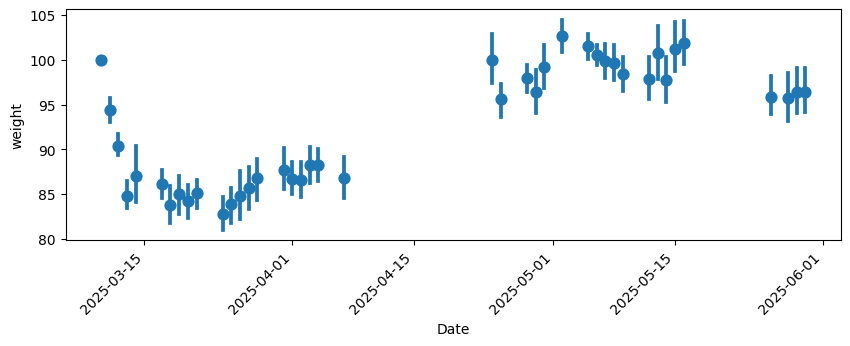

In [79]:
fig, ax = plt.subplots(figsize=(10, 3))
sns.pointplot(data=melted_df, x='date', y='weight', native_scale= True, linestyles="")
plt.xticks(rotation=45, ha='right')
plt.xlabel('Date')
plt.show()

/tmp/ipykernel_948659/1822571976.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['daily_weight_variation'] = filtered_df.groupby('subject')['weight'].diff()
/tmp/ipykernel_948659/1822571976.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['time_diff_days'] = filtered_df.groupby('subject')['date'].diff().dt.days


(array([20203., 20207., 20209., 20213., 20217., 20221., 20225., 20229.,
        20233., 20237.]),
 [Text(20203.0, 0, '2025-04-25'),
  Text(20207.0, 0, '2025-04-29'),
  Text(20209.0, 0, '2025-05-01'),
  Text(20213.0, 0, '2025-05-05'),
  Text(20217.0, 0, '2025-05-09'),
  Text(20221.0, 0, '2025-05-13'),
  Text(20225.0, 0, '2025-05-17'),
  Text(20229.0, 0, '2025-05-21'),
  Text(20233.0, 0, '2025-05-25'),
  Text(20237.0, 0, '2025-05-29')])

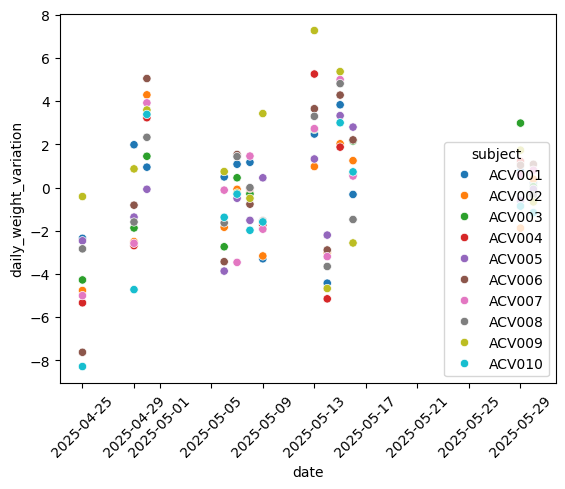

In [95]:
# explore the relationship between how much weight variation has been from day to day, and how much water they drank in the task between these times.
# restrict the analysis to the data from the 15th of march to the 15th of April
start_date = pd.to_datetime('2025-04-15')
end_date = pd.to_datetime('2025-06-15')
filtered_df = melted_df[(melted_df['date'] >= start_date) & (melted_df['date'] <= end_date)]

# calculate the daily weight variation
filtered_df['daily_weight_variation'] = filtered_df.groupby('subject')['weight'].diff()
# calculate the time difference in days
filtered_df['time_diff_days'] = filtered_df.groupby('subject')['date'].diff().dt.days

# restrict to rows where the time difference is 1 day
filtered_df = filtered_df[filtered_df['time_diff_days'] == 1]
# drop nans
filtered_df = filtered_df.dropna()

# plot the daily weight variation against the date
sns.scatterplot(data=filtered_df, x='date', y='daily_weight_variation', hue='subject')
plt.xticks(rotation=45)


In [96]:
filtered_df

,subject,date,weight,daily_weight_variation,time_diff_days
220,ACV001,2025-04-25,93.411552,-2.34657,1.0
221,ACV002,2025-04-25,97.227645,-4.763764,1.0
222,ACV003,2025-04-25,88.298755,-4.273859,1.0
223,ACV004,2025-04-25,99.117323,-5.332843,1.0
224,ACV005,2025-04-25,97.537879,-2.462121,1.0
...,...,...,...,...,...
405,ACV006,2025-05-30,97.564276,1.082544,1.0
406,ACV007,2025-05-30,93.576923,0.807692,1.0
407,ACV008,2025-05-30,97.553398,-0.349515,1.0
408,ACV009,2025-05-30,100.619835,-0.661157,1.0


In [86]:
# get data on water consumption
import lecilab_behavior_analysis.utils as utils
import lecilab_behavior_analysis.df_transforms as dft
import lecilab_behavior_analysis.plots as plots
from pathlib import Path
tv_projects = utils.get_server_projects()
animals = utils.get_animals_in_project(tv_projects[1])
animals_to_remove = ['test', 'test2']
animals = [animal for animal in animals if animal not in animals_to_remove]
# retrieve the data for the remaining animals
for mouse in animals:
    local_path = Path(utils.get_outpath()) / Path(tv_projects[1]) / Path("sessions") / Path(mouse)
    # create the directory if it doesn't exist
    local_path.mkdir(parents=True, exist_ok=True)
    # download the session data
    utils.rsync_session_data(
        project_name=tv_projects[1],
        animal=mouse,
        local_path=str(local_path),
        credentials=utils.get_idibaps_cluster_credentials(),
    )

df_list = []
for mouse in animals:
    local_path = Path(utils.get_outpath()) / Path(tv_projects[1]) / Path("sessions") / Path(mouse)
    andf = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")
    df_list.append(andf)
    print(f"Loaded data for {mouse}.")
# concatenate the dataframes
behavdf = pd.concat(df_list, ignore_index=True)

receiving incremental file list
ACV001.csv

sent 45,788 bytes  received 8,887 bytes  15,621.43 bytes/sec
total size is 42,647,843  speedup is 780.02
receiving incremental file list
ACV002.csv

sent 46,670 bytes  received 1,290,910 bytes  297,240.00 bytes/sec
total size is 51,700,995  speedup is 38.65
receiving incremental file list
ACV003.csv

sent 48,616 bytes  received 21,409 bytes  20,007.14 bytes/sec
total size is 48,197,954  speedup is 688.30
receiving incremental file list
ACV004.csv

sent 34,681 bytes  received 1,086,978 bytes  249,257.56 bytes/sec
total size is 39,479,764  speedup is 35.20
receiving incremental file list
ACV005.csv

sent 34,699 bytes  received 187,731 bytes  49,428.89 bytes/sec
total size is 34,388,053  speedup is 154.60
receiving incremental file list
ACV006.csv

sent 45,970 bytes  received 72,170 bytes  26,253.33 bytes/sec
total size is 43,426,614  speedup is 367.59
receiving incremental file list
ACV007.csv

sent 43,114 bytes  received 483,574 bytes  150,482

/tmp/ipykernel_948659/1874514336.py:26: DtypeWarning: Columns (13,14,17,18,27,28,29,30,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  andf = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")


Loaded data for ACV001.


/tmp/ipykernel_948659/1874514336.py:26: DtypeWarning: Columns (13,14,27,28,29,30,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  andf = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")


Loaded data for ACV002.


/tmp/ipykernel_948659/1874514336.py:26: DtypeWarning: Columns (13,14,17,18,27,28,29,30,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  andf = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")


Loaded data for ACV003.


/tmp/ipykernel_948659/1874514336.py:26: DtypeWarning: Columns (13,14,27,28,29,30,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  andf = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")


Loaded data for ACV004.


/tmp/ipykernel_948659/1874514336.py:26: DtypeWarning: Columns (13,14,27,28,29,30,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  andf = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")


Loaded data for ACV005.


/tmp/ipykernel_948659/1874514336.py:26: DtypeWarning: Columns (13,14,17,18,27,28,29,30,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  andf = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")


Loaded data for ACV006.


/tmp/ipykernel_948659/1874514336.py:26: DtypeWarning: Columns (13,14,17,18,27,28,29,30,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  andf = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")


Loaded data for ACV007.


/tmp/ipykernel_948659/1874514336.py:26: DtypeWarning: Columns (13,14,17,18,27,28,29,30,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  andf = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")


Loaded data for ACV008.


/tmp/ipykernel_948659/1874514336.py:26: DtypeWarning: Columns (13,14,17,18,27,28,29,30,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  andf = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")


Loaded data for ACV009.


/tmp/ipykernel_948659/1874514336.py:26: DtypeWarning: Columns (13,14,17,18,27,28,29,30,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.
  andf = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")


Loaded data for ACV010.


In [97]:
filtered_df['water_consumption'] = np.nan
# calculate the water consumption for each subject on the 24 hours previous to the date, at 9am
for row in filtered_df.itertuples():
    subject = row.subject
    date = row.date
    date9am = date.replace(hour=9, minute=0, second=0, microsecond=0)
    previous_date9am = date9am - pd.Timedelta(days=1)
    # get the water consumption for the subject on the date
    subject_df = behavdf[behavdf['subject'] == subject]
    # convert date column to datetime
    subject_df['date'] = pd.to_datetime(subject_df['date'], format='%Y-%m-%d %H:%M:%S')
    subject_date_df = subject_df[(subject_df['date'] >= previous_date9am) & (subject_df['date'] < date9am)]
    total_water_consumption = subject_date_df['water'].sum()
    filtered_df.loc[row.Index, 'water_consumption'] = total_water_consumption

/tmp/ipykernel_948659/224842569.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subject_df['date'] = pd.to_datetime(subject_df['date'], format='%Y-%m-%d %H:%M:%S')
/tmp/ipykernel_948659/224842569.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subject_df['date'] = pd.to_datetime(subject_df['date'], format='%Y-%m-%d %H:%M:%S')
/tmp/ipykernel_948659/224842569.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

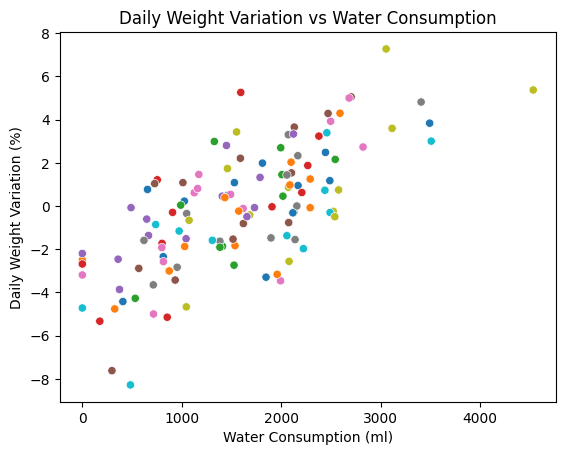

In [98]:
# plot the correlation between daily weight variation and water consumption
sns.scatterplot(data=filtered_df, x='water_consumption', y='daily_weight_variation', hue='subject')
plt.xlabel('Water Consumption (ml)')
plt.ylabel('Daily Weight Variation (%)')
plt.title('Daily Weight Variation vs Water Consumption')
#remove legend
plt.legend([], [], frameon=False)
plt.show()